In [1]:
using Bloqade
using Distributions
using LegendrePolynomials
using PythonCall
using LinearAlgebra
using Printf

include("../src/BloqadeControl.jl")
using .BloqadeControl

In [18]:
# Define adiabatic pulses
ts = 1.0
vmax1 = 3.99*2*pi
vmax2 = 9.99*2*pi


#function adb_pulse_x_(t::Float64)
#    if t <= 0.08*ts
#        return vmax1 * t/(0.08*ts);
#    elseif 0.08*ts < t <= 0.8*ts
#        return vmax1;
#    elseif 0.8*ts < t <= ts
#        return vmax1*(ts-t)/(0.2*ts);
#    end
#end


function adb_pulse_x_(t::Float64)
    if t <= 0.1*ts
        return vmax1 * t/(0.1*ts);
    elseif 0.1*ts < t <= 0.8*ts
        return vmax1;
    elseif 0.8*ts < t <= 0.9*ts
        return vmax1*(0.9*ts-t)/(0.1*ts);
    elseif 0.9*ts < t <= ts
        return vmax1*(t-0.9*ts)/(0.1*ts);
    end
end

function adb_pulse_z_(t::Float64)
    return 2*vmax2*t/ts;
end

function adb_pulse_x(t::Float64)
    return - log(8*pi/(adb_pulse_x_(t)) - 1);
end

function adb_pulse_z(t::Float64)
    return - log(40*pi/(adb_pulse_z_(t)) - 1);
end

# Specify parametrization of waveforms
n_sites = 8
basis = "spectral"
n_basis = 8
use_sigmoid_envolope = true
f0 = [adb_pulse_x, adb_pulse_z]

# Specify training parameters
params = zeros(Float64, (2, n_basis))
lr = 2e-3
w_l2 = 1e-3
n_iter = 500
method = "adam"

# Specify parameters of Rydberg atoms
distance = 5.95
atom_config = generate_sites(ChainLattice(), n_sites, scale=distance);
local_detuning = ones(Float64, n_sites)
for j in 1:n_sites
    if mod(j,2) == 1
        local_detuning[j] -= 1.0
    end
end
global_detuning = -20*pi
n_samples = 5

# Specify target state
target_state = arrayreg(bit"10101010")
J = UniformScaling(1.)
tar_op = density_matrix(target_state).state
M = J - tar_op;
M = GeneralMatrixBlock(M; nlevel=2);

In [19]:
# Setup optimizer
generator = WaveformGenerator(n_sites, basis, n_basis, use_sigmoid_envolope, f0, ts)
model = BloqadeModel(atom_config, local_detuning, global_detuning, n_samples, M);
optim = Optimizer(params, lr, w_l2, n_iter, method)

Optimizer([0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], 0.002, 0.001, 500, "adam", [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0])

Initial loss function value is 0.308.

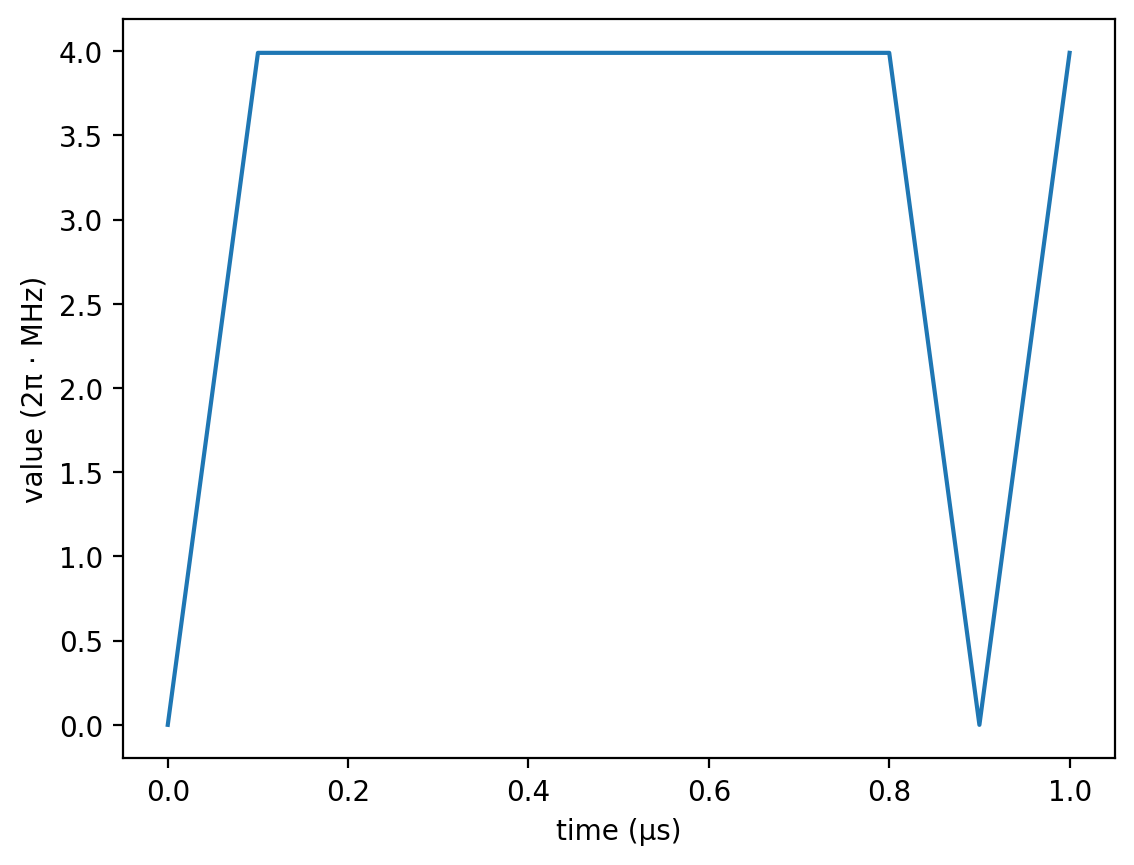

In [22]:
update_waveform!(model, generator, optim.params)
@printf "Initial loss function value is %.3f." compute_loss(model, generator, optim)
Bloqade.plot(generator.Ω1)
#Bloqade.plot(generator.Δ1[1])
#Bloqade.plot(generator.Δ1[2])

In [11]:
# Start fine tuning 
train_loss!(model, generator, optim)

epoch: 10, loss = 0.2685, loss_l2 = 0.000000
epoch: 20, loss = 0.2159, loss_l2 = 0.000000
epoch: 30, loss = 0.1699, loss_l2 = 0.000000
epoch: 40, loss = 0.1303, loss_l2 = 0.000001
epoch: 50, loss = 0.0881, loss_l2 = 0.000001
epoch: 60, loss = 0.0614, loss_l2 = 0.000001
epoch: 70, loss = 0.0495, loss_l2 = 0.000002
epoch: 80, loss = 0.0394, loss_l2 = 0.000002
epoch: 90, loss = 0.0322, loss_l2 = 0.000002
epoch: 100, loss = 0.0284, loss_l2 = 0.000002
epoch: 110, loss = 0.0268, loss_l2 = 0.000003
epoch: 120, loss = 0.0263, loss_l2 = 0.000003
epoch: 130, loss = 0.0261, loss_l2 = 0.000003
epoch: 140, loss = 0.0261, loss_l2 = 0.000003
epoch: 150, loss = 0.0263, loss_l2 = 0.000003
epoch: 160, loss = 0.0265, loss_l2 = 0.000003
epoch: 170, loss = 0.0266, loss_l2 = 0.000003
epoch: 180, loss = 0.0266, loss_l2 = 0.000003
epoch: 190, loss = 0.0259, loss_l2 = 0.000003
epoch: 200, loss = 0.0257, loss_l2 = 0.000003
epoch: 210, loss = 0.0260, loss_l2 = 0.000003
epoch: 220, loss = 0.0258, loss_l2 = 0.0000

The fine-tuned parameters are:
[0.0 -0.2359463831134342 0.16720591768056758 -0.2299498918534547 0.120331997701151 -0.18165426639224058 -0.08030191411950413 0.020658590162959987; 0.0 0.01864758245731501 -0.09846292325447369 0.041912717465864 -0.04576787176740364 0.056526712875402695 0.11734586486361144 -0.024427884229250126]
Current loss function value is 0.025.

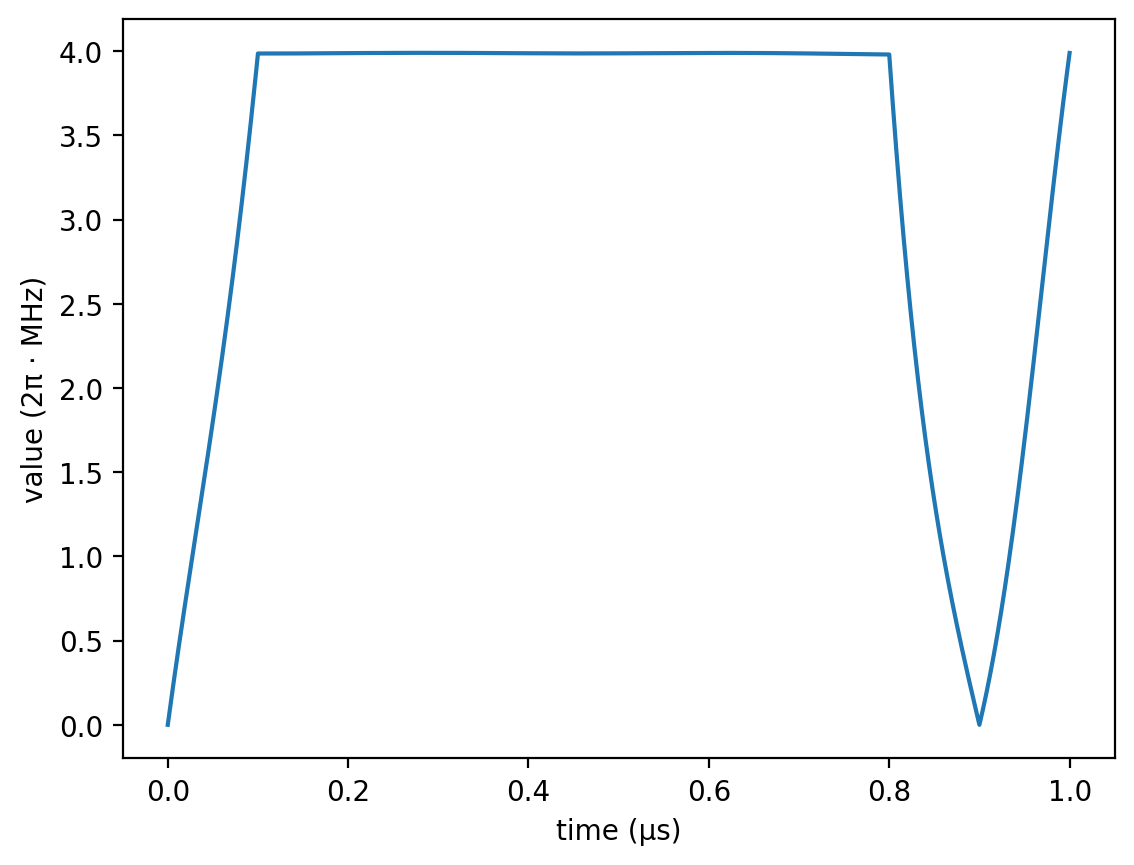

In [17]:
# Fine-tuned pulse visualization
@printf "The fine-tuned parameters are:\n"
print(optim.params,"\n")
update_waveform!(model, generator, optim.params)
@printf "Current loss function value is %.3f." compute_loss(model, generator, optim)
Bloqade.plot(generator.Ω1)

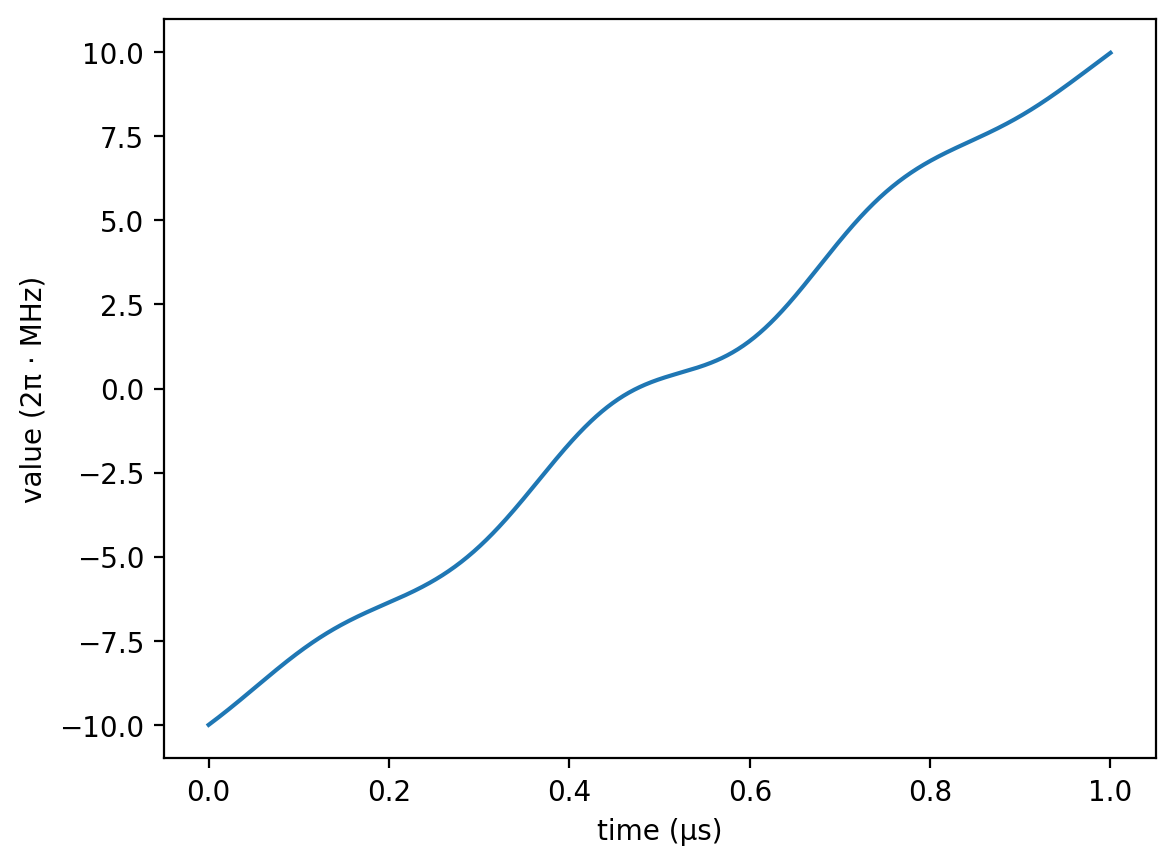

In [13]:
Bloqade.plot(generator.Δ1[2])